# Fine-tuning con LoRA de ConvNextV2 Large — Entrada: imagen (meme)

## Importar librerías

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import json
import os
from pathlib import Path
from PIL import Image

from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    precision_recall_curve,
    roc_curve,
    auc
)

from transformers import (
    AutoImageProcessor,
    ConvNextV2Model,
    TrainingArguments,
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput

from peft import LoraConfig, get_peft_model

from pyevall.evaluation import PyEvALLEvaluation
from pyevall.metrics.metricfactory import MetricFactory

## Configuración y parámetros

In [ ]:
os.environ["HF_TOKEN"] = ""

MODEL_NAME = "facebook/convnextv2-large-22k-224"
MAIN_PATH  = ".."
GROUP_ID   = "BeingChillingWeWillWin"
MODEL_ID   = "convnextv2LargeImg"

LABEL_COLUMN = "label"

DATA_TRAIN_PATH = os.path.join(MAIN_PATH, "preprocessed_data", "train_split.json")
DATA_VAL_PATH   = os.path.join(MAIN_PATH, "preprocessed_data", "dev_split.json")
DATA_TEST_PATH  = os.path.join(MAIN_PATH, "preprocessed_data", "test_split.json")

DATA_BASE_DIR   = os.path.join(MAIN_PATH, "materials","dataset_task2_exist2026")

OUTPUT_DIR      = os.path.join(MAIN_PATH, "weigths", "ConvNextV2-Large_img_lora")
SAVE_PATH       = os.path.join(MAIN_PATH, "weigths", "ConvNextV2-Large_img_final")
PREDICTIONS_DIR = os.path.join(MAIN_PATH, "predictions")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cuda


## Carga y preprocesamiento de datos

In [3]:
def load_json_dataset(path):
    """Carga el JSON orientado a diccionario y devuelve un DataFrame."""
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return pd.DataFrame(data.values())

train_df = load_json_dataset(DATA_TRAIN_PATH)
val_df   = load_json_dataset(DATA_VAL_PATH)
test_df  = load_json_dataset(DATA_TEST_PATH)

label_map         = {"NO": 0, "YES": 1}
label_map_inverse = {0: "NO", 1: "YES"}

train_df["label_int"] = train_df[LABEL_COLUMN].map(label_map)
val_df["label_int"]   = val_df[LABEL_COLUMN].map(label_map)
test_df["label_int"]  = -1

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"\nEjemplo de ruta de imagen: {train_df['path_memes'].iloc[0]}")
print(f"\nDistribución de etiquetas en TRAIN:")
print(train_df[LABEL_COLUMN].value_counts())
print(f"\nDistribución de etiquetas en VAL:")
print(val_df[LABEL_COLUMN].value_counts())

Train size: 2146 | Val size: 537 | Test size: 687

Ejemplo de ruta de imagen: memes/111945.jpeg

Distribución de etiquetas en TRAIN:
label
YES    1282
NO      864
Name: count, dtype: int64

Distribución de etiquetas en VAL:
label
YES    321
NO     216
Name: count, dtype: int64


## Dataset PyTorch con carga de imágenes

In [4]:
class MemeImageDataset(Dataset):
    """
    Dataset que carga imágenes de memes desde disco.
    Las rutas `path_memes` son relativas al directorio base del JSON.
    """
    def __init__(self, df, base_dir, processor, is_test=False):
        self.df        = df.reset_index(drop=True)
        self.base_dir  = Path(base_dir)
        self.processor = processor
        self.is_test   = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row      = self.df.iloc[idx]
        img_path = self.base_dir / row["path_memes"]

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            # Si la imagen no se puede abrir, devolvemos un tensor negro
            print(f"[WARN] No se pudo abrir {img_path}: {e}")
            image = Image.new("RGB", (224, 224), color=0)

        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze(0)  # (3, H, W)

        sample = {
            "pixel_values": pixel_values,
            "id_EXIST": str(row["id_EXIST"]),
        }

        if not self.is_test:
            sample["labels"] = torch.tensor(row["label_int"], dtype=torch.float)

        return sample

## Carga del procesador y creación de los datasets

In [5]:
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

train_dataset = MemeImageDataset(train_df, DATA_BASE_DIR, processor, is_test=False)
eval_dataset  = MemeImageDataset(val_df,   DATA_BASE_DIR, processor, is_test=False)
test_dataset  = MemeImageDataset(test_df,  DATA_BASE_DIR, processor, is_test=True)

print(f"Train: {len(train_dataset)} | Val: {len(eval_dataset)} | Test: {len(test_dataset)}")

sample = train_dataset[0]
print(f"pixel_values shape: {sample['pixel_values'].shape}")
print(f"label            : {sample['labels']}")

preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

The image processor of type `ConvNextImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Train: 2146 | Val: 537 | Test: 687
pixel_values shape: torch.Size([3, 224, 224])
label            : 1.0


## Modelo ConvNextV2 con LoRA y cabeza de clasificación binaria

ConvNextV2 es una red convolucional moderna. Aplicamos LoRA a las capas lineales internas (`pwconv1`, `pwconv2`) de cada bloque ConvNextV2. El pooler global produce un vector de características que pasa al clasificador binario.

In [6]:
class ConvNextV2Classifier(nn.Module):
    """
    ConvNextV2 Large con LoRA aplicado a capas lineales internas
    de los bloques ConvNextV2 + cabeza lineal binaria.
    El backbone (con LoRA) produce el pooler_output que se pasa al clasificador.
    """
    def __init__(self, backbone, hidden_size=1536):
        super().__init__()
        self.backbone   = backbone
        self.classifier = nn.Linear(hidden_size, 1)

    def forward(self, pixel_values, labels=None):
        outputs    = self.backbone(pixel_values=pixel_values)
        # ConvNextV2Model devuelve pooler_output como vector global
        pooled     = outputs.pooler_output
        logits     = self.classifier(pooled).squeeze(-1)

        loss = None
        if labels is not None:
            loss = nn.BCEWithLogitsLoss()(logits, labels.float())

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits.unsqueeze(-1),  # (B, 1) para consistencia con compute_metrics
        )


# --- Cargar backbone base ---
backbone    = ConvNextV2Model.from_pretrained(MODEL_NAME)
hidden_size = backbone.config.hidden_sizes[-1]  # 1536 para ConvNextV2-Large
print(f"Hidden size (último stage): {hidden_size}")

# --- Configurar LoRA ---
# ConvNextV2 usa bloques con capas lineales 'pwconv1' y 'pwconv2'.
# Son las capas point-wise del bloque depthwise separable.
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["pwconv1", "pwconv2"],
    bias="none",
)

backbone = get_peft_model(backbone, lora_config)
backbone.print_trainable_parameters()

model = ConvNextV2Classifier(backbone=backbone, hidden_size=hidden_size)

total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\ntotal trainable (backbone LoRA + clasificador): {trainable_params:,} / {total_params:,} "
      f"({100 * trainable_params / total_params:.4f}%)")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/792M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/378 [00:00<?, ?it/s]

ConvNextV2Model LOAD REPORT from: facebook/convnextv2-large-22k-224
Key               | Status     |  | 
------------------+------------+--+-
classifier.bias   | UNEXPECTED |  | 
classifier.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Hidden size (último stage): 1536


trainable params: 4,331,520 || all params: 200,751,360 || trainable%: 2.1577

total trainable (backbone LoRA + clasificador): 4,333,057 / 200,752,897 (2.1584%)


## Métricas de evaluación

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits_tensor  = torch.tensor(logits).squeeze(-1)
    probs          = torch.sigmoid(logits_tensor).numpy()
    preds          = (probs >= 0.5).astype(int)

    if labels is None or (hasattr(labels, '__iter__') and any(l < 0 for l in labels)):
        return {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary', zero_division=0
    )
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## Collator personalizado para el Trainer

In [8]:
def collate_fn(batch):
    """Agrupa muestras en un batch, ignorando id_EXIST en el forward."""
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    collated     = {"pixel_values": pixel_values}

    if "labels" in batch[0]:
        collated["labels"] = torch.stack([item["labels"] for item in batch])

    # id_EXIST no se pasa al modelo pero se conserva aparte si es necesario
    return collated

## Entrenamiento

In [9]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=5,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    bf16=True,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    dataloader_num_workers=4,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

trainer.train()

os.makedirs(SAVE_PATH, exist_ok=True)

model.backbone.save_pretrained(SAVE_PATH)
torch.save(model.classifier.state_dict(), os.path.join(SAVE_PATH, "classifier_head.pth"))
print(f"Modelo guardado en: {SAVE_PATH}")

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.674059,0.607076,0.616034,0.909657,0.734591
2,No log,0.659214,0.610801,0.625000,0.872274,0.728218
3,No log,0.654762,0.621974,0.634703,0.866044,0.732543
4,0.628975,0.651336,0.625698,0.643541,0.838006,0.728011
5,0.628975,0.650972,0.627561,0.646489,0.831776,0.727520


Modelo guardado en: ../weigths/ConvNextV2-Large_img_final


## Inferencia en DEV y cálculo del threshold óptimo (F1)

Mejor Threshold (DEV, max-F1): 0.3469
F1 en ese threshold           : 0.7483
Probabilidades guardadas en: ../predictions/BeingChillingWeWillWin_convnextv2LargeImg_probs_dev.json

Métricas en DEV con threshold óptimo (0.3469):
  Accuracy : 0.5978
  Precision: 0.5978
  Recall   : 1.0000
  F1-Score : 0.7483

AUC (DEV): 0.5460


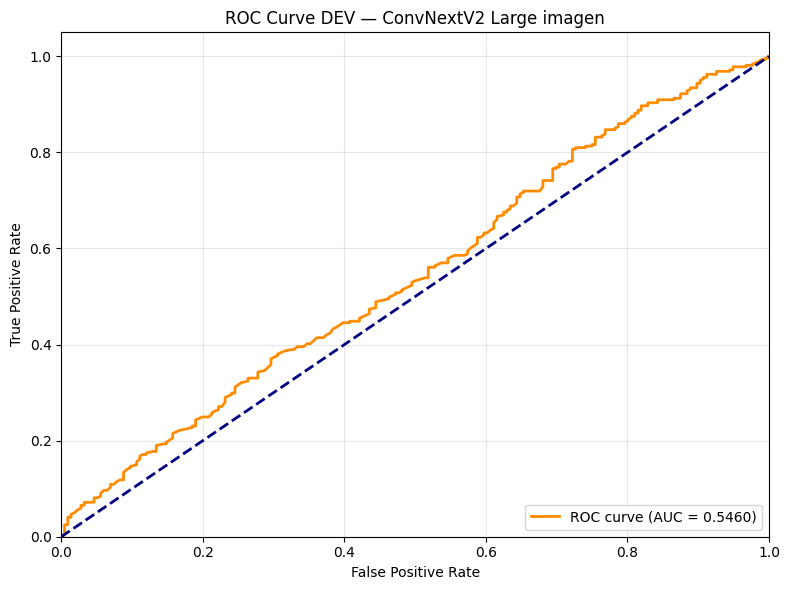

In [10]:
def save_probs_json(ids, probs, split_name, labels=None):
    records = []
    for i, (id_exist, prob) in enumerate(zip(ids, probs)):
        rec = {'id': str(id_exist), 'prob_YES': round(float(prob), 6)}
        if labels is not None:
            rec['label'] = label_map_inverse[int(labels[i])]
        records.append(rec)
    path = os.path.join(PREDICTIONS_DIR, f'{GROUP_ID}_{MODEL_ID}_probs_{split_name}.json')
    with open(path, 'w', encoding='utf-8') as f:
        json.dump(records, f, ensure_ascii=False, indent=2)
    print(f"Probabilidades guardadas en: {path}")


dev_predictions = trainer.predict(eval_dataset)

dev_logits  = torch.tensor(dev_predictions.predictions).squeeze(-1)
y_probs_dev = torch.sigmoid(dev_logits).numpy()
y_true_dev  = dev_predictions.label_ids

precisions, recalls, thresholds = precision_recall_curve(y_true_dev, y_probs_dev)
f1_scores         = (2 * precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx       = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Mejor Threshold (DEV, max-F1): {optimal_threshold:.4f}")
print(f"F1 en ese threshold           : {f1_scores[optimal_idx]:.4f}")

dev_preds_optimal = (y_probs_dev >= optimal_threshold).astype(int)
precision_opt, recall_opt, f1_opt, _ = precision_recall_fscore_support(
    y_true_dev, dev_preds_optimal, average='binary', zero_division=0
)
acc_opt = accuracy_score(y_true_dev, dev_preds_optimal)

save_probs_json(val_df['id_EXIST'].values, y_probs_dev, 'dev', labels=val_df['label_int'].values)

print(f"\nMétricas en DEV con threshold óptimo ({optimal_threshold:.4f}):")
print(f"  Accuracy : {acc_opt:.4f}")
print(f"  Precision: {precision_opt:.4f}")
print(f"  Recall   : {recall_opt:.4f}")
print(f"  F1-Score : {f1_opt:.4f}")

fpr, tpr, _ = roc_curve(y_true_dev, y_probs_dev)
roc_auc = auc(fpr, tpr)

print(f"\nAUC (DEV): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DEV — ConvNextV2 Large imagen')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Evaluación en DEV con PyEvALL

In [11]:
dev_preds_for_pyevall = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label_map_inverse[pred]}
    for id_exist, pred in zip(val_df['id_EXIST'].values, dev_preds_optimal)
]
dev_preds_df   = pd.DataFrame(dev_preds_for_pyevall)
dev_preds_path = os.path.join(PREDICTIONS_DIR, 'dev_predictions_temp.json')
with open(dev_preds_path, 'w', encoding='utf-8') as f:
    f.write(dev_preds_df.to_json(orient='records'))

dev_gold = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label}
    for id_exist, label in zip(val_df['id_EXIST'].values, val_df[LABEL_COLUMN].values)
]
dev_gold_df   = pd.DataFrame(dev_gold)
dev_gold_path = os.path.join(PREDICTIONS_DIR, 'dev_gold_temp.json')
with open(dev_gold_path, 'w', encoding='utf-8') as f:
    f.write(dev_gold_df.to_json(orient='records'))

test_eval = PyEvALLEvaluation()
metrics   = [MetricFactory.Accuracy.value, MetricFactory.FMeasure.value]
report    = test_eval.evaluate(dev_preds_path, dev_gold_path, metrics)
print("\n=== Evaluación en DEV con PyEvALL ===")
report.print_report()

2026-03-01 10:34:34,106 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['Accuracy', 'FMeasure']


2026-03-01 10:34:34,139 - pyevall.metrics.metrics - INFO -             evaluate() - Executing accuracy evaluation method


2026-03-01 10:34:34,197 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method



=== Evaluación en DEV con PyEvALL ===
{
  "metrics": {
    "Accuracy": {
      "name": "Accuracy",
      "acronym": "Acc",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "average": 0.5977653631284916
        }],
        "average_per_test_case": 0.5977653631284916
      }
    },
    "FMeasure": {
      "name": "F-Measure",
      "acronym": "F1",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "classes": {
            "YES": 0.7482517482517482,
            "NO": 0
          },
          "average": 0.3741258741258741
        }],
        "average_per_test_case": 0.3741258741258741
      }
    }
  },
  "files": {
    "dev_predictions_temp.json": {
      "name": "dev_predictions_temp.json",
      "status": "OK",
      "gold": false,
      "description": "Use parameter: report=\"embedded\"!",
      "er

## Inferencia en TEST y generación de predicciones finales

In [12]:
test_predictions = trainer.predict(test_dataset)

test_logits  = torch.tensor(test_predictions.predictions).squeeze(-1)
y_probs_test = torch.sigmoid(test_logits).numpy()
test_preds   = (y_probs_test >= optimal_threshold).astype(int)

save_probs_json(test_df['id_EXIST'].values, y_probs_test, 'test')

print(f"\nPredicciones en TEST (threshold={optimal_threshold:.4f}):")
print(f"  Total   : {len(test_preds)}")
print(f"  YES     : {np.sum(test_preds == 1)} ({100*np.mean(test_preds == 1):.2f}%)")
print(f"  NO      : {np.sum(test_preds == 0)} ({100*np.mean(test_preds == 0):.2f}%)")

Probabilidades guardadas en: ../predictions/BeingChillingWeWillWin_convnextv2LargeImg_probs_test.json

Predicciones en TEST (threshold=0.3469):
  Total   : 687
  YES     : 682 (99.27%)
  NO      : 5 (0.73%)


## Guardar predicciones en formato PyEvALL para TEST

In [13]:
test_preds_for_submission = [
    {'test_case': 'EXIST2025', 'id': str(id_exist), 'value': label_map_inverse[pred]}
    for id_exist, pred in zip(test_df['id_EXIST'].values, test_preds)
]
test_preds_df = pd.DataFrame(test_preds_for_submission)

output_filename = f"{GROUP_ID}_{MODEL_ID}.json"
output_path     = os.path.join(PREDICTIONS_DIR, output_filename)

with open(output_path, 'w', encoding='utf-8') as f:
    f.write(test_preds_df.to_json(orient='records'))

print(f"\nPredicciones guardadas en: {output_path}")


Predicciones guardadas en: ../predictions/BeingChillingWeWillWin_convnextv2LargeImg.json
